# TAT-C: Coverage Analysis Example

This example demonstrates how to use direct function calls of the low-level TAT-C library to perform coverage analysis.

## Space System Model

First we define the satellites for a mission. In this example we define one satellite (NOAA-1) with a single instrument and an orbit derived from a known two-line element set (TLE). The TLE defines the orbital state at an instant in time which can be used to determine future positions of the satellite. The example TLE below for NOAA-1 was collected from [CelesTrak](https://celestrak.org/) around February 2022.

TAT-C allows several types of orbit specifications, one of which being the `TwoLineElements` specification which requires the TLE as an argument.

In [15]:
tle = [
    "1 04793U 70106A   22044.41526573 -.00000035  00000+0  54783-4 0  9991",
    "2 04793 101.5750 111.2777 0031771 203.0437 167.8944 12.54003052342042",
]
from tatc.schemas import TwoLineElements
orbit = TwoLineElements(tle=tle)

Next, we define an instrument to perform observations. The most important parameter is the _field of regard_ which sets the view angle from the satellite to the Earth's surface. The example below assumes a 30 degree field of regard.

In [16]:
from tatc.schemas import Instrument
instrument = Instrument(name="Lead Instrument", field_of_regard=30)

Finally, we can combine the orbit and instrument to define a new satellite.

In [17]:
from tatc.schemas import Satellite
satellite = Satellite(name="NOAA1", orbit=orbit, instruments=[instrument])

## Mission Parameters
Next, we define the point of interest to observe using geodetic coordinates.

In [23]:
from tatc.schemas import Point
point = Point(id=0, latitude=40.74259, longitude=-74.02686)

Next, we can identify the starting and ending time of a sample mission period. The starting time is noon UTC on February 1, 2022 and the ending time is 30 days later (noon UTC on March 3, 2022).

In [28]:
start = datetime(
    year=2022, month=2, day=1, hour=12, tzinfo=timezone.utc
)
end = start + timedelta(days=30)

## Analysis Functions

The `collect_observations` analysis function identifies all of the observation opportunities of a point by a satellite instrument between the starting and ending time. Results are formatted as a GeoDataFrame which is similar to a regular DataFrame with a geospatial column labeled `geometry`.

In [36]:
from tatc.analysis import collect_observations
results = collect_observations(point, satellite, instrument, start, end)
display(results)

,point_id,geometry,satellite,instrument,start,end,epoch,sat_alt,sat_az
0,0,POINT (-74.02686 40.74259),NOAA1,Lead Instrument,2022-02-01 15:15:36.187413+00:00,2022-02-01 15:17:20.589099+00:00,2022-02-01 15:16:28.388256+00:00,78.241416,107.399349
1,0,POINT (-74.02686 40.74259),NOAA1,Lead Instrument,2022-02-02 02:13:24.617550+00:00,2022-02-02 02:15:33.513492+00:00,2022-02-02 02:14:29.065521+00:00,83.237496,257.534597
2,0,POINT (-74.02686 40.74259),NOAA1,Lead Instrument,2022-02-04 02:05:32.101666+00:00,2022-02-04 02:07:50.525297+00:00,2022-02-04 02:06:41.313481500+00:00,88.960936,29.740582
3,0,POINT (-74.02686 40.74259),NOAA1,Lead Instrument,2022-02-06 01:57:55.015833+00:00,2022-02-06 01:59:52.932554+00:00,2022-02-06 01:58:53.974193500+00:00,81.748883,64.879912
4,0,POINT (-74.02686 40.74259),NOAA1,Lead Instrument,2022-02-08 01:50:28.442597+00:00,2022-02-08 01:51:43.054262+00:00,2022-02-08 01:51:05.748429500+00:00,74.589067,67.330499
5,0,POINT (-74.02686 40.74259),NOAA1,Lead Instrument,2022-02-08 15:45:00.147428+00:00,2022-02-08 15:45:59.206613+00:00,2022-02-08 15:45:29.677020500+00:00,73.326744,290.393698
6,0,POINT (-74.02686 40.74259),NOAA1,Lead Instrument,2022-02-10 15:36:44.711653+00:00,2022-02-10 15:38:42.628012+00:00,2022-02-10 15:37:43.669832500+00:00,80.551895,285.591334
7,0,POINT (-74.02686 40.74259),NOAA1,Lead Instrument,2022-02-12 15:28:51.469762+00:00,2022-02-12 15:30:59.639173+00:00,2022-02-12 15:29:55.554467500+00:00,87.986027,266.220564
8,0,POINT (-74.02686 40.74259),NOAA1,Lead Instrument,2022-02-14 15:21:02.578320+00:00,2022-02-14 15:23:07.527471+00:00,2022-02-14 15:22:05.052895500+00:00,84.170592,110.411924
9,0,POINT (-74.02686 40.74259),NOAA1,Lead Instrument,2022-02-15 02:19:17.517225+00:00,2022-02-15 02:20:58.228085+00:00,2022-02-15 02:20:07.872655+00:00,77.324790,254.666461


The `aggregate_observations` function groups observations of points to compute metrics like access and revisit.

In [34]:
from tatc.analysis import aggregate_observations
aggregated_results = aggregate_observations(results)
display(aggregated_results)

,point_id,geometry,satellite,instrument,start,epoch,end,access,revisit
obs,,,,,,,,,
0,0,POINT (-74.02686 40.74259),NOAA1,Lead Instrument,2022-02-01 15:15:36.187413+00:00,2022-02-01 15:16:28.388256+00:00,2022-02-01 15:17:20.589099+00:00,0 days 00:01:44.401686,NaT
1,0,POINT (-74.02686 40.74259),NOAA1,Lead Instrument,2022-02-02 02:13:24.617550+00:00,2022-02-02 02:14:29.065520896+00:00,2022-02-02 02:15:33.513492+00:00,0 days 00:02:08.895942,0 days 10:59:57.326079
2,0,POINT (-74.02686 40.74259),NOAA1,Lead Instrument,2022-02-04 02:05:32.101666+00:00,2022-02-04 02:06:41.313481472+00:00,2022-02-04 02:07:50.525297+00:00,0 days 00:02:18.423631,1 days 23:54:25.907747
3,0,POINT (-74.02686 40.74259),NOAA1,Lead Instrument,2022-02-06 01:57:55.015833+00:00,2022-02-06 01:58:53.974193408+00:00,2022-02-06 01:59:52.932554+00:00,0 days 00:01:57.916721,1 days 23:54:20.830888
4,0,POINT (-74.02686 40.74259),NOAA1,Lead Instrument,2022-02-08 01:50:28.442597+00:00,2022-02-08 01:51:05.748429568+00:00,2022-02-08 01:51:43.054262+00:00,0 days 00:01:14.611665,1 days 23:53:48.038429
5,0,POINT (-74.02686 40.74259),NOAA1,Lead Instrument,2022-02-08 15:45:00.147428+00:00,2022-02-08 15:45:29.677020416+00:00,2022-02-08 15:45:59.206613+00:00,0 days 00:00:59.059185,0 days 13:55:30.764016
6,0,POINT (-74.02686 40.74259),NOAA1,Lead Instrument,2022-02-10 15:36:44.711653+00:00,2022-02-10 15:37:43.669832448+00:00,2022-02-10 15:38:42.628012+00:00,0 days 00:01:57.916359,1 days 23:53:42.480584
7,0,POINT (-74.02686 40.74259),NOAA1,Lead Instrument,2022-02-12 15:28:51.469762+00:00,2022-02-12 15:29:55.554467584+00:00,2022-02-12 15:30:59.639173+00:00,0 days 00:02:08.169411,1 days 23:54:14.927520
8,0,POINT (-74.02686 40.74259),NOAA1,Lead Instrument,2022-02-14 15:21:02.578320+00:00,2022-02-14 15:22:05.052895488+00:00,2022-02-14 15:23:07.527471+00:00,0 days 00:02:04.949151,1 days 23:54:16.057709


TAT-C includes a supplemental method to reduce observations to descriptive statistics.

In [35]:
from tatc.analysis import reduce_observations
reduced_results = reduce_observations(aggregated_results)
display(reduced_results)

,point_id,geometry,access,revisit,samples
point_id,,,,,
0,0,POINT (-74.02686 40.74259),0 days 00:01:44.323389,1 days 10:10:48.679474,21


## Visualization

Using external libraries, we can visualize the point.

In [55]:
from tatc.generation import generate_cubed_sphere_points
points_df = generate_cubed_sphere_points(5000000)

In [24]:
import geoplot as gplt
import contextily as ctx
ax = gplt.pointplot(points_df)
ctx.add_basemap(ax, crs=points.crs)

In [56]:
points = points_df.apply(lambda r: Point(id=r.point_id, latitude=r.geometry.y, longitude=r.geometry.x), axis=1)

In [78]:
import time
t = time.time()
results_list = [collect_observations(point, satellite, instrument, start, end) for point in points]
print(f"Operation took {time.time() - t:.2f} seconds")

Operation took 2.10 seconds


In [80]:
from joblib import Parallel, delayed
t = time.time()
results_list = Parallel(n_jobs=-1)(delayed(collect_observations)(point, sat, instrument, start, end) for point in points)
print(f"Operation took {time.time() - t:.2f} seconds")

Operation took 1.33 seconds


In [81]:
import pandas as pd
results = pd.concat(results_list, ignore_index=True)
aggregated_results = aggregate_observations(results)
display(aggregated_results)
reduced_results = reduce_observations(aggregated_results)
display(reduced_results)

,point_id,geometry,satellite,instrument,start,epoch,end,access,revisit
obs,,,,,,,,,
0,2,POINT (-67.58495 -67.51699),NOAA1,Lead Instrument,2022-02-01 12:01:31.338082+00:00,2022-02-01 12:03:05.359197440+00:00,2022-02-01 12:04:39.380313+00:00,0 days 00:03:08.042231,NaT
1,30,POINT (112.27912 67.38106),NOAA1,Lead Instrument,2022-02-01 12:58:25.019587+00:00,2022-02-01 12:59:06.332337920+00:00,2022-02-01 12:59:47.645089+00:00,0 days 00:01:22.625502,0 days 00:58:16.307007
2,27,POINT (-22.61894 67.38106),NOAA1,Lead Instrument,2022-02-01 13:11:13.177400+00:00,2022-02-01 13:12:19.582592+00:00,2022-02-01 13:13:25.987784+00:00,0 days 00:02:12.810384,0 days 00:15:00.968197
3,29,POINT (67.31310 67.38106),NOAA1,Lead Instrument,2022-02-01 14:54:12.498379+00:00,2022-02-01 14:55:02.803638016+00:00,2022-02-01 14:55:53.108897+00:00,0 days 00:01:40.610518,0 days 01:44:39.931497
4,1,POINT (-112.55097 -67.51699),NOAA1,Lead Instrument,2022-02-01 15:50:36.531080+00:00,2022-02-01 15:51:27.306322432+00:00,2022-02-01 15:52:18.081565+00:00,0 days 00:01:41.550485,0 days 00:58:05.583186
...,...,...,...,...,...,...,...,...,...
1010,31,POINT (157.24514 67.38106),NOAA1,Lead Instrument,2022-03-03 09:04:46.143262+00:00,2022-03-03 09:05:46.512015104+00:00,2022-03-03 09:06:46.880768+00:00,0 days 00:02:00.737506,0 days 00:32:11.670793
1011,3,POINT (-22.61894 -67.51699),NOAA1,Lead Instrument,2022-03-03 10:01:42.540302+00:00,2022-03-03 10:02:06.756686080+00:00,2022-03-03 10:02:30.973070+00:00,0 days 00:00:48.432768,0 days 00:57:44.829808
1012,0,POINT (-157.51699 -67.51699),NOAA1,Lead Instrument,2022-03-03 10:14:07.269072+00:00,2022-03-03 10:15:15.122456064+00:00,2022-03-03 10:16:22.975840+00:00,0 days 00:02:15.706768,0 days 00:14:40.435538


,point_id,geometry,access,revisit,samples
point_id,,,,,
0,0,POINT (-157.51699 -67.51699),0 days 00:01:43.118394,0 days 00:46:17.231826,48
1,1,POINT (-112.55097 -67.51699),0 days 00:01:44.223501,0 days 00:46:52.936750,47
2,2,POINT (-67.58495 -67.51699),0 days 00:01:41.466202,0 days 00:47:27.665714,48
3,3,POINT (-22.61894 -67.51699),0 days 00:01:44.730614,0 days 00:46:19.550160,47
4,4,POINT (22.34708 -67.51699),0 days 00:01:44.931036,0 days 00:45:55.974367,47
5,5,POINT (67.31310 -67.51699),0 days 00:01:46.516779,0 days 00:45:43.815492,46
6,6,POINT (112.27912 -67.51699),0 days 00:01:46.749086,0 days 00:45:36.400313,46
7,7,POINT (157.24514 -67.51699),0 days 00:01:44.113907,0 days 00:46:04.795971,47
8,8,POINT (-157.51699 -22.55097),0 days 00:01:45.949674,0 days 00:38:07.395414,16


In [73]:
import pandas as pd
aggregated_results_list = [aggregate_observations(results) for results in results_list]
aggregated_results = pd.concat(aggregated_results_list, ignore_index=True)
display(aggregated_results)
reduced_results = reduce_observations(aggregated_results)
display(reduced_results)

,point_id,geometry,satellite,instrument,start,epoch,end,access,revisit
0,0,POINT (-157.51699 -67.51699),NOAA1,Lead Instrument,2022-02-01 17:46:45.694727+00:00,2022-02-01 17:47:24.828913920+00:00,2022-02-01 17:48:03.963101+00:00,0 days 00:01:18.268374,NaT
1,0,POINT (-157.51699 -67.51699),NOAA1,Lead Instrument,2022-02-02 18:38:55.528565+00:00,2022-02-02 18:39:56.938391040+00:00,2022-02-02 18:40:58.348217+00:00,0 days 00:02:02.819652,1 days 00:54:12.653490
2,0,POINT (-157.51699 -67.51699),NOAA1,Lead Instrument,2022-02-03 10:10:43.768386+00:00,2022-02-03 10:11:49.502348544+00:00,2022-02-03 10:12:55.236311+00:00,0 days 00:02:11.467925,0 days 15:33:59.707746
3,0,POINT (-157.51699 -67.51699),NOAA1,Lead Instrument,2022-02-03 17:39:19.032414+00:00,2022-02-03 17:39:36.634631936+00:00,2022-02-03 17:39:54.236850+00:00,0 days 00:00:35.204436,0 days 07:29:10.468464
4,0,POINT (-157.51699 -67.51699),NOAA1,Lead Instrument,2022-02-04 11:04:00.950079+00:00,2022-02-04 11:04:19.028053504+00:00,2022-02-04 11:04:37.106028+00:00,0 days 00:00:36.155949,0 days 17:25:18.073614
...,...,...,...,...,...,...,...,...,...
1010,31,POINT (157.24514 67.38106),NOAA1,Lead Instrument,2022-03-01 01:45:03.374555+00:00,2022-03-01 01:45:55.643754496+00:00,2022-03-01 01:46:47.912954+00:00,0 days 00:01:44.538399,1 days 00:54:19.326276
1011,31,POINT (157.24514 67.38106),NOAA1,Lead Instrument,2022-03-01 09:12:30.697129+00:00,2022-03-01 09:13:35.438721024+00:00,2022-03-01 09:14:40.180313+00:00,0 days 00:02:09.483184,0 days 07:29:36.805758
1012,31,POINT (157.24514 67.38106),NOAA1,Lead Instrument,2022-03-02 00:44:50.891916+00:00,2022-03-02 00:45:29.432382976+00:00,2022-03-02 00:46:07.972850+00:00,0 days 00:01:17.080934,0 days 15:33:37.275721
1013,31,POINT (157.24514 67.38106),NOAA1,Lead Instrument,2022-03-03 01:37:07.630364+00:00,2022-03-03 01:38:06.807431936+00:00,2022-03-03 01:39:05.984500+00:00,0 days 00:01:58.354136,1 days 00:54:15.092584


,point_id,geometry,access,revisit,samples
point_id,,,,,
0,0,POINT (-157.51699 -67.51699),0 days 00:01:43.118394,0 days 15:11:14.744444,48
1,1,POINT (-112.55097 -67.51699),0 days 00:01:44.223501,0 days 15:08:19.378954,47
2,2,POINT (-67.58495 -67.51699),0 days 00:01:41.466202,0 days 15:20:43.250397,48
3,3,POINT (-22.61894 -67.51699),0 days 00:01:44.730614,0 days 15:20:31.751067,47
4,4,POINT (22.34708 -67.51699),0 days 00:01:44.931036,0 days 15:20:31.361938,47
5,5,POINT (67.31310 -67.51699),0 days 00:01:46.516779,0 days 15:28:30.633296,46
6,6,POINT (112.27912 -67.51699),0 days 00:01:46.749086,0 days 15:40:57.754633,46
7,7,POINT (157.24514 -67.51699),0 days 00:01:44.113907,0 days 15:08:19.820985,47
8,8,POINT (-157.51699 -22.55097),0 days 00:01:45.949674,1 days 20:49:58.965695,16


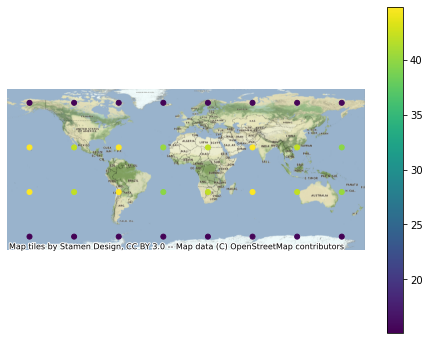

In [74]:
reduced_results["revisit_hr"] = reduced_results.revisit/timedelta(hours=1)
ax = gplt.pointplot(reduced_results, hue="revisit_hr", legend=True)
ctx.add_basemap(ax, crs=reduced_results.crs)